In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from scipy.spatial import ConvexHull
from scipy.ndimage import gaussian_filter1d
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib import cm
from rd_solver import *
from itertools import combinations, product
import importlib
import warnings
warnings.filterwarnings("ignore")

from shared import *

In [2]:
import simulation_loader
importlib.reload(simulation_loader)
simulations = simulation_loader.Simulations(
    result_path="/run/media/cdmium/9A986168986143BB/proofreading/result_20250225",
    parameter_path="parameters_20250225",
)
betas = ["baseline"]
for b in simulations.get_keys():
    if b != betas[0]:
        betas.append(b)

Parameters loaded.
{('parameters', None): (40000, 4)}
reading baseline
Simulations result loaded.
{'baseline': (40000, 7)}


In [3]:
xlim = [-1, 10]
ylim = [-5, 2]
aspect_ratio = 1
branch_name = "intracellular"

In [4]:
# Desired plot area size for each subplot (in inches)
PLOT_WIDTH = 2.5
PLOT_HEIGHT = 2.5
LEFT_MARGIN = 0.8   # Space for y-tick labels
BOTTOM_MARGIN = 0.6  # Space for x-tick labels
TITLE_SPACE = 0.4   # Space for subplot title
RIGHT_MARGIN = 0.2  # Right buffer
TOP_BUFFER = 0.4

def format_10n(x, pos):
    return f"$10^{{{int(x)}}}$"


def format_subplots(fig, axes, plot_width=PLOT_WIDTH, plot_height=PLOT_HEIGHT):
    """
    Adjust subplots from plt.subplots() to have a fixed plot area size with reserved space.
    Args:
        fig: Matplotlib Figure object
        axes: Array of Axes objects (or single Axes)
        plot_width: Width of each subplot's plot area (inches)
        plot_height: Height of each subplot's plot area (inches)
    """
    # Normalize axes to 2D array
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    if axes.ndim == 1:
        axes = axes.reshape(-1, 1)
    n_rows, n_cols = axes.shape

    # Calculate total figure size based on fixed dimensions
    total_plot_width = n_cols * plot_width
    total_plot_height = n_rows * (plot_height + TITLE_SPACE)  # Add title space per row
    fig_width = LEFT_MARGIN + total_plot_width + RIGHT_MARGIN
    fig_height = BOTTOM_MARGIN + total_plot_height + TOP_BUFFER

    # Resize figure
    fig.set_size_inches(fig_width, fig_height)

    # Reposition each subplot
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            # Position in figure coordinates (0-1)
            left = (LEFT_MARGIN + j * plot_width) / fig_width
            # Bottom starts from top, accounting for title space
            bottom = (TOP_BUFFER + (n_rows - 1 - i) * (plot_height + TITLE_SPACE) + TITLE_SPACE) / fig_height
            width = plot_width / fig_width
            height = plot_height / fig_height
            ax.set_position([left, bottom, width, height])

            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.spines['left'].set_color('k')
            ax.spines['left'].set_linewidth(1.0)
            ax.spines['bottom'].set_color('k')
            ax.spines['bottom'].set_linewidth(1.0)
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_10n))
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_10n))

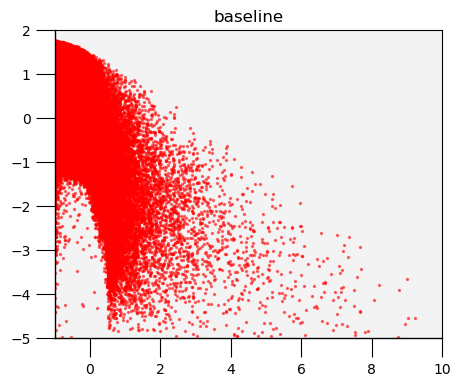

In [5]:
# basic scatter plot
fig, axs = plt.subplots(len(betas), 1, figsize=(5, len(betas) * 4))
axs = np.array([axs])

for i, beta in enumerate(betas):
    axs[i].scatter(
        simulations.get_fidelity_log(beta),
        simulations.get_AC_log(beta),
        2, color='red', alpha=0.5
    )
    axs[i].title.set_text(beta)
for ax in axs.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.plot([0, 25], [1.5, -11])

    ax.set_facecolor('#F3F3F3')
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1.0)

    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)
    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)

# plt.savefig("simple_scatter.svg")
plt.show()

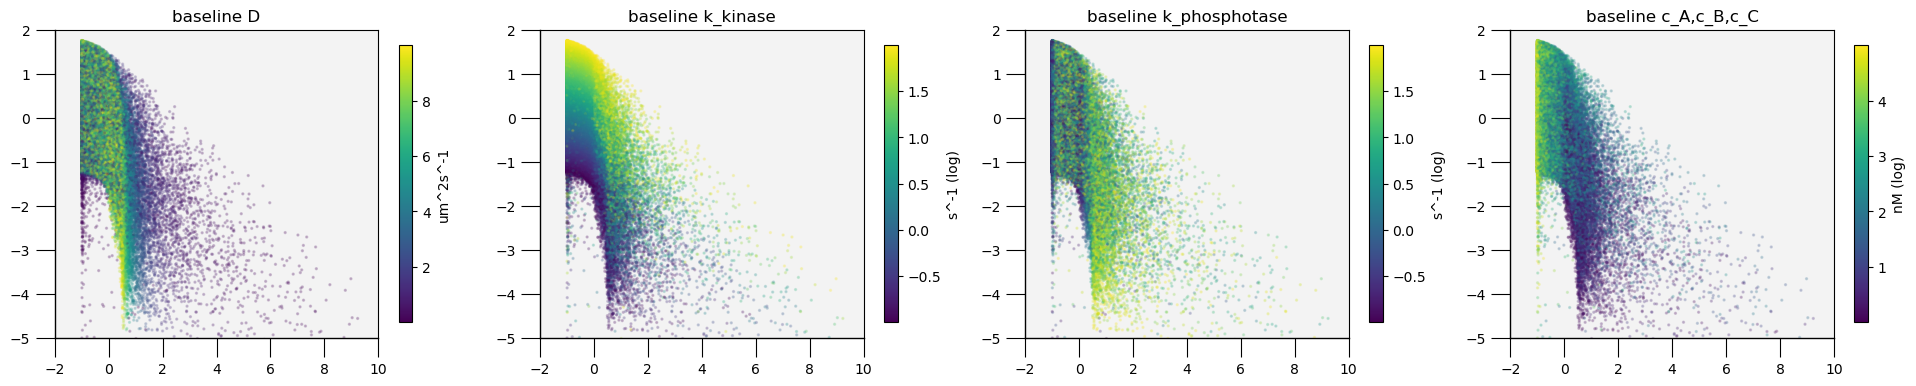

In [55]:
# basic scatter plot
fig, axs = plt.subplots(
    len(betas), num_dimensions, figsize=(
        6 * num_dimensions, len(betas) * 4))
axs = np.array([axs])
parameter_name = ["D", "k_kinase", "k_phosphotase", "c_A,c_B,c_C"]
parameter_unit = ["um^2s^-1", "s^-1 (log)", "s^-1 (log)", "nM (log)"]

for i, beta in enumerate(betas):
    for j in range(0, num_dimensions):
        p = axs[i, j].scatter(
            simulations.get_fidelity_log(beta),
            simulations.get_AC_log(beta),
            2, c=simulations.get_parameters_log()[:, j], alpha=0.2
        )
        axs[i, j].title.set_text("{} {}".format(beta, parameter_name[j]))

        # recreate color bar for solid color
        parameters_log = simulations.get_parameters_log()[:, j]
        norm = matplotlib.colors.Normalize(
            vmin=parameters_log.min(),
            vmax=parameters_log.max()
        )
        cbar = fig.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap="viridis"),
            shrink=0.9, ax=axs[i, j],
            label=parameter_unit[j]
        )
for ax in axs.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.plot([0, 25], [1.5, -11])

    ax.set_facecolor('#F3F3F3')
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1.0)

    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)
    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)

# plt.savefig("simple_scatter.svg")
plt.show()

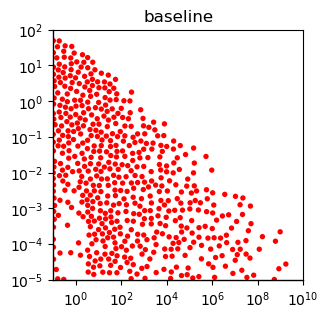

In [6]:
import matplotlib.ticker as ticker

# add subset of proofreading and enough concentration
for b in betas:
    simulations.add_subset(
        ("proofreading", b),
        np.bitwise_and(
            simulations.get_fidelity_log(b) > 0,
            simulations.get_subset(subsets=[("valid", b)])
        )
    )
for b in betas:
    simulations.add_subset(
        ("active", b),
        np.bitwise_and(
            simulations.get_AC_log(b) > -1,
            simulations.get_subset(subsets=[("valid", b)])
        )
    )

# simplified scatter
distance_threshold = 0.022

# create subset for simplified data
for b in betas:
    subset = []
    f_simple = np.array([])
    ac_simple = np.array([])
    for f, ac in zip(
        simulations.get_fidelity_log(b), simulations.get_AC_log(b)
    ):
        if f < xlim[0] or f > xlim[1] or ac < ylim[0] or ac > ylim[1]:
            subset.append(False)
        elif np.all(
            np.linalg.norm(
                np.array(
                    [
                        (f_simple - f) / (xlim[1] - xlim[0]),
                        (ac_simple - ac) / (ylim[1] - ylim[0]) * aspect_ratio
                    ]
                ),
                axis=0
            ) > distance_threshold
        ):
            f_simple = np.append(f_simple, f)
            ac_simple = np.append(ac_simple, ac)
            subset.append(True)
        else:
            subset.append(False)
    subset = np.array(subset)
    # increase point number for group with too small point set
    if b != "baseline" and len(f_simple) < np.count_nonzero(
        simulations.get_subset(subsets=[("simplified", "baseline")])
    ):
        false_indices = np.where(subset == False)[0]
        indices_to_change = np.random.choice(
            false_indices,
            size=np.count_nonzero(
                simulations.get_subset(subsets=[("simplified", "baseline")])
            ) - len(f_simple),
            replace=False
        )
        subset[indices_to_change] = True

    simulations.add_subset(
        ("simplified", b),
        subset
    )


fig, axs = plt.subplots(len(betas), 1, figsize=(5, len(betas) * 4))
axs = np.array([axs])

for i, b in enumerate(betas):
    axs[i].scatter(
        simulations.get_fidelity_log(
            beta=b, subsets=["simplified"]
        ),
        simulations.get_AC_log(
            beta=b, subsets=["simplified"]
        ),
        15,
        color='red',
        alpha=1,
        edgecolor="none",
    )
    axs[i].title.set_text(b)

format_subplots(fig, axs)

plt.savefig(branch_name + "simplified_scatter.svg")
plt.show()
#  TODO highlight

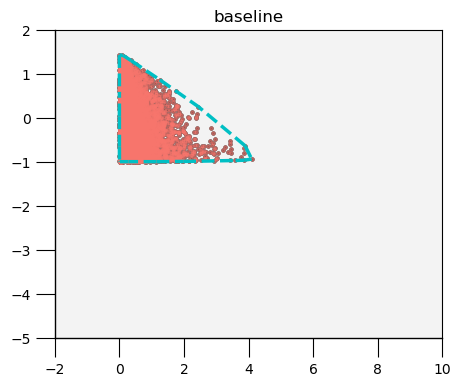

In [66]:

ggcolors = {
    1: ["#F8766D"],
    2: ["#F8766D", "#00BFC4"],
    3: ["#F8766D", "#00BA38", "#619CFF"],
    4: ["#F8766D", "#7CAE00", "#00BFC4", "#C77CFF"],
    5: ["#F8766D", "#A3A500", "#00BF7D", "#00B0F6", "#E76BF3"],
    6: ["#F8766D", "#B79F00", "#00BA38", "#00BFC4", "#619CFF", "#F564E3"],
    7: ["#F8766D", "#C49A00", "#53B400", "#00C094", "#00B6EB", "#A58AFF", "#FB61D7"],
    8: ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"],
}


# * analyze shifted points

# hull_data_fidelity_AC_log = np.array(
#     [heatmap_data_fidelity_log, heatmap_data_AC_log]
# ).T
# hull_data_fidelity_AC_log_feedback = np.array(
#     [heatmap_data_fidelity_log_feedback, heatmap_data_AC_log_feedback]
# ).T

# create convex hull object
hull = ConvexHull(
    np.array([
        simulations.get_fidelity_log(beta="baseline", subsets=["proofreading", "active", "valid"]),
        simulations.get_AC_log(beta="baseline", subsets=["proofreading", "active", "valid"]),
    ]).T
)


def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p) >= 0


# calcualte which points (with feedback) is inside convex hull (without
# feedback) or not
for b in betas:
    simulations.add_subset(
        ("in_hull", b),
        in_hull(
            np.array([
                simulations.get_fidelity_log(beta=b),
                simulations.get_AC_log(beta=b)
            ]).T,
            hull.points
        )
    )


# plot
fig, axs = plt.subplots(len(betas), 1, figsize=(5, (len(betas) - 0) * 4))
axs = np.array([axs])
for i, b in enumerate(betas):
    # scatter for beta==0 (no feedback)
    axs[i].scatter(
        simulations.get_fidelity_log(beta="baseline", subsets=["in_hull"]),
        simulations.get_AC_log(beta="baseline", subsets=["in_hull"]),
        5,
        color=[0.25, 0.25, 0.25],
        alpha=1
    )
    # draw convex hull
    for simplex in hull.simplices:
        axs[i].plot(
            simulations.get_fidelity_log(
                beta="baseline", subsets=["proofreading", "active"]
            )[simplex],
            simulations.get_AC_log(
                beta="baseline", subsets=["proofreading", "active"]
            )[simplex],
            "--",
            color=ggcolors[2][1],
            lw=2.5,
        )
    # scatter for inside hull
    axs[i].scatter(
        simulations.get_fidelity_log(beta=b, subsets=["in_hull"]),
        simulations.get_AC_log(beta=b, subsets=["in_hull"]),
        5,
        color=ggcolors[2][0],
        alpha=0.5,
    )
    # scatter for outside hull
    axs[i].scatter(
        simulations.get_fidelity_log(
            beta=b, subsets=["proofreading", "active"], not_subsets=["in_hull"]
        ),
        simulations.get_AC_log(
            beta=b, subsets=["proofreading", "active"], not_subsets=["in_hull"]
        ),
        5,
        color="red",
        alpha=0.5,
    )
    axs[i].title.set_text(b)

for ax in axs.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.plot([0, 25], [1.5, -11])

    ax.set_facecolor('#F3F3F3')
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1.0)

    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)
    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)

plt.savefig("convex_hall.svg", dpi=150)
plt.show()


In [80]:
for b in betas:
    print(
        "beta: {}, inside triangle: {}, outside trignale: {}, total: {}"
        .format(
            b,
            len(
                simulations.get_AC(
                    beta=b,
                    subsets=["valid", "proofreading", "active", "in_hull"]
                )
            ),
            len(
                simulations.get_AC(
                    beta=b,
                    subsets=["valid", "proofreading", "active"],
                    not_subsets=["in_hull"]
                )
            ),
            len(
                simulations.get_AC(
                    beta=b, subsets=["valid", "proofreading", "active"]
                )
            )
        )
    )

beta: baseline, inside triangle: 2125, outside trignale: 0, total: 2125
beta: b_ac1_k_ac3, inside triangle: 2408, outside trignale: 2694, total: 5102
beta: b_ac0.5, inside triangle: 2641, outside trignale: 2001, total: 4642
beta: b_ac1_k_ac6, inside triangle: 2262, outside trignale: 2358, total: 4620
beta: b_ac1, inside triangle: 2416, outside trignale: 2955, total: 5371
beta: b_ac1_n_ac6, inside triangle: 1001, outside trignale: 4142, total: 5143
beta: b_ac1_n_ac3, inside triangle: 1250, outside trignale: 4100, total: 5350
beta: b_ac_rp1, inside triangle: 2240, outside trignale: 14561, total: 16801
beta: b_rp1, inside triangle: 119, outside trignale: 6162, total: 6281
beta: b_ac2, inside triangle: 1120, outside trignale: 4000, total: 5120
beta: sender_ratio3, inside triangle: 2151, outside trignale: 12, total: 2163
beta: sender_region451, inside triangle: 0, outside trignale: 0, total: 0


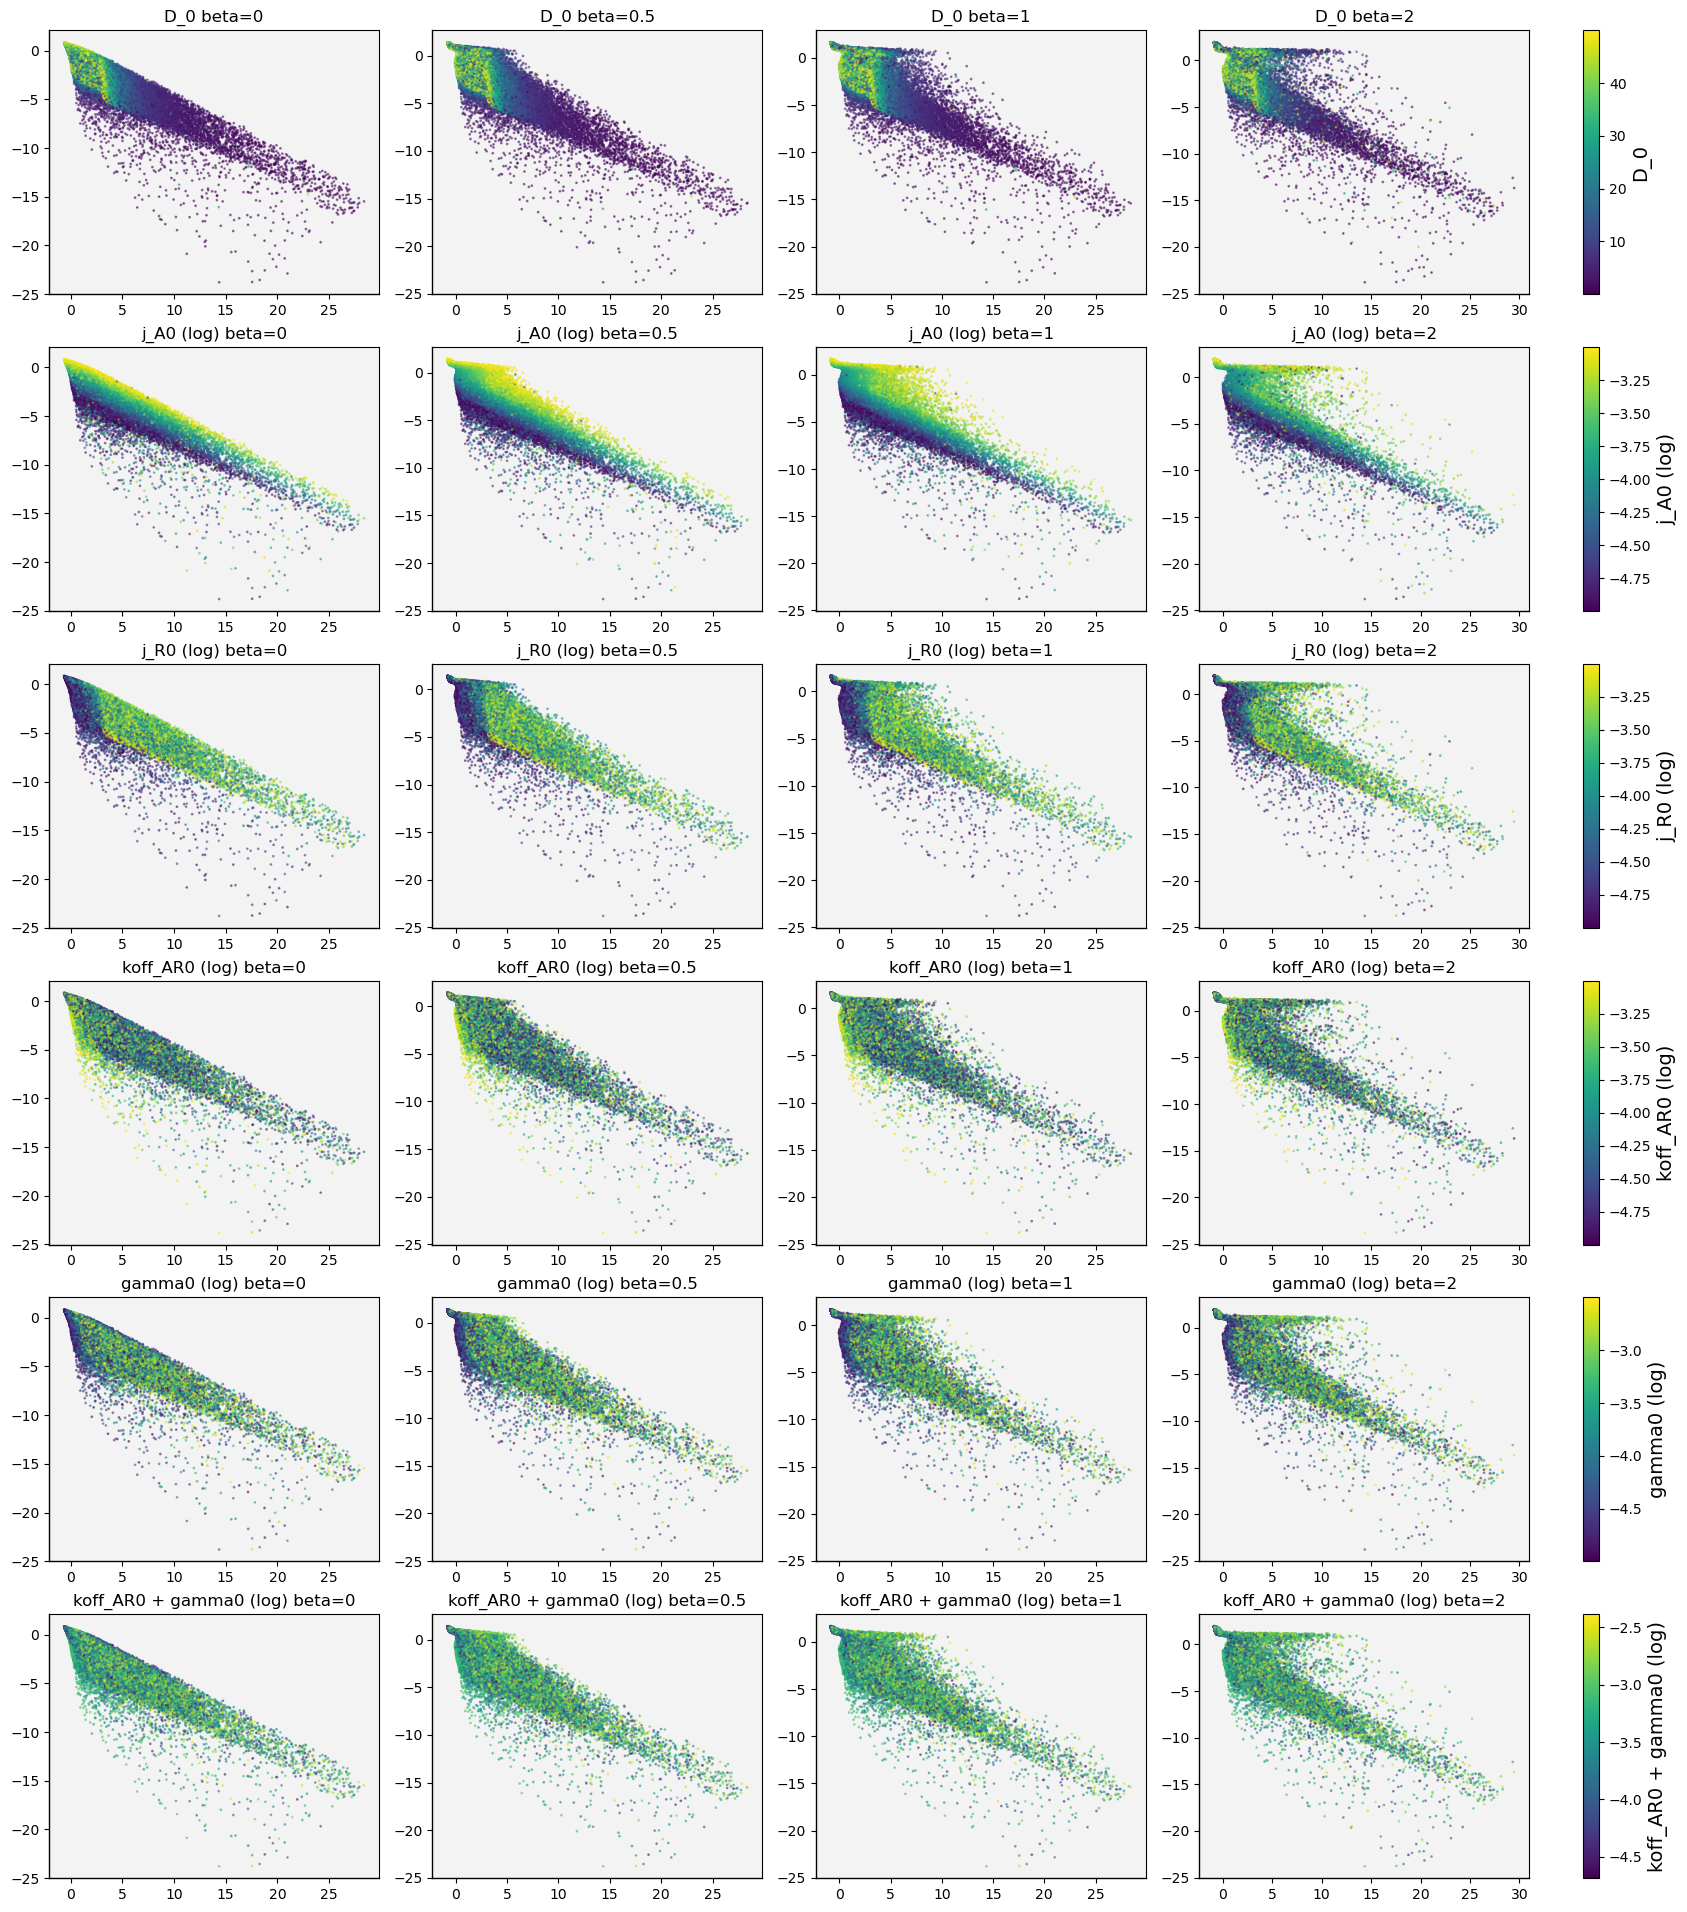

In [14]:
# distribution of each paramters
fig, axs = plt.subplots(
    6, 5, figsize=(20, 24), width_ratios=[1, 1, 1, 1, 0.05]
)

for (i, parameter) in enumerate([
    "D_0",
    "j_A0 (log)",
    "j_R0 (log)",
    "koff_AR0 (log)",
    "gamma0 (log)",
    "koff_AR0 + gamma0 (log)"
]):
    norm = Normalize(
        vmin=np.nanmin(simulations.get_parameters_log()[:, i]),
        vmax=np.nanmax(simulations.get_parameters_log()[:, i]))
    cmap = cm.viridis  # 颜色映射
    colors = cmap(norm(simulations.get_parameters_log()[:, i]))

    for j, b in enumerate(betas):
        axs[i][j].scatter(
            simulations.get_fidelity_log(beta=b),
            simulations.get_AC_log(beta=b),
            1,
            color=colors,
            alpha=0.5
        )
        axs[i][j].title.set_text(parameter + " beta=" + str(b))

    cbar = fig.colorbar(
        cm.ScalarMappable(norm=norm, cmap=cmap), cax=axs[i, -1]
    )
    cbar.set_label(parameter, fontsize=14)

for ax in axs[:, :-1].flatten():
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)
    # ax.plot([0, 25], [1.5, -11], c="red")

    ax.set_facecolor('#F3F3F3')
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1.0)

plt.show()

In [11]:
# # divide each paramter into several parts and observe their distribution
# parts = 4
# fig, axs = plt.subplots(6, parts, figsize=(parts * 5, 24))

# for (i, parameter) in enumerate([
#     "D_0",
#     "j_A0 (log)",
#     "j_R0 (log)",
#     "koff_AR0 (log)",
#     "gamma0 (log)",
#     "koff_AR0 + gamma0 (log)"
# ]):
#     parameter_data_without_feedback = parameters_without_feedback_valid[:, i]
#     sort_indices_without_feedback = parameter_data_without_feedback.argsort()
#     parameter_data_with_feedback = parameters_with_feedback_valid[:, i]
#     sort_indices_with_feedback = parameter_data_with_feedback.argsort()

#     for j, ((i_without_feedback, i_with_feedback)) in enumerate(zip(
#         np.array_split(sort_indices_without_feedback, 4),
#         np.array_split(sort_indices_with_feedback, 4),
#     )):
#         # Change point color to red
#         axs[i][j].scatter(
#             heatmap_data_fidelity_log[(i_without_feedback)],
#             heatmap_data_AC_log[(i_without_feedback)],
#             1,
#             color=[0.4, 0.4, 0.4],
#             alpha=0.1
#         )
#         axs[i][j].scatter(
#             heatmap_data_fidelity_log_feedback[(i_with_feedback)],
#             heatmap_data_AC_log_feedback[(i_with_feedback)],
#             1,
#             color="red",
#             alpha=0.1
#         )
#         axs[i][j].title.set_text(
#             "{} {:.2f}-{:.2f} {:.2f}-{:.2f}".format(
#                 parameter,
#                 parameter_data_without_feedback[(i_without_feedback)].min(),
#                 parameter_data_without_feedback[(i_without_feedback)].max(),
#                 parameter_data_with_feedback[(i_with_feedback)].min(),
#                 parameter_data_with_feedback[(i_with_feedback)].max(),
#             )
#         )

#         axs[i][j].set_xlim(xlim)
#         axs[i][j].set_ylim(ylim)
#         axs[i][j].plot([0, 25], [1.5, -11], c="blue")

#         axs[i][j].set_facecolor('#F3F3F3')
#         axs[i][j].spines['left'].set_color('k')
#         axs[i][j].spines['left'].set_linewidth(1.0)
#         axs[i][j].spines['bottom'].set_color('k')
#         axs[i][j].spines['bottom'].set_linewidth(1.0)

#         publish_on = True
#         if publish_on:
#             axs[i][j].tick_params(axis="y", labelleft=True, size=14)
#             axs[i][j].tick_params(axis="x", labelbottom=True, size=14)
#             # plt.savefig('figures fig3a(3).svg', dpi=150)
#         else:
#             axs[i][j].set_ylabel(
#                 r'concentration of $AA_{p}$ (nM)', fontsize=14
#             )
#             axs[i][j].set_xlabel(
#                 r'fidelity, $\log_{10}(AA_{p}/BA_{p})$',
#                 fontsize=14
#             )


# plt.show()

In [12]:
# x_min = xlim[0]
# x_max = xlim[1]
# y_min = ylim[0]
# y_max = ylim[1]
# nbins = 100
# X, Y = np.mgrid[x_min:x_max:nbins * 1j, y_min:y_max:nbins * 1j]
# indices = np.vstack([X.ravel(), Y.ravel()])
# kernel = gaussian_kde(np.swapaxes(hull_data_fidelity_AC_log, 0, 1))
# Z_without_feedback = np.reshape(kernel(indices).T, X.shape)
# kernel = gaussian_kde(np.swapaxes(hull_data_fidelity_AC_log_feedback, 0, 1))
# Z_with_feedback = np.reshape(kernel(indices).T, X.shape)
# Z_overlap = np.minimum(Z_without_feedback, Z_with_feedback)
# Z_difference = Z_with_feedback - Z_without_feedback

In [13]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# # Change point color to red
# # axs[0].imshow(
# #     np.rot90(Z_without_feedback), cmap=plt.cm.gist_earth_r,
# #           extent=[x_min, x_max, y_min, y_max]
# #     )
# percentile = 80
# fig.suptitle("{} percentile".format(percentile))
# axs[0].contour(
#     X,
#     Y,
#     Z_without_feedback,
#     colors='blue',
#     linewidths=1,
#     alpha=1,
#     linestyles="solid",
#     label="Group 1",
#     # levels=[
#     #     np.percentile(Z_without_feedback, percentile),
#     # ],
# )
# # axs[1].contourf(X, Y, Z_difference, levels=20, cmap='RdBu', alpha=0.8, label="Difference")
# axs[1].contour(
#     X,
#     Y,
#     Z_without_feedback,
#     colors="blue",
#     linewidths=1,
#     alpha=1,
#     linestyles="solid",
#     label="Group 1",
#     # levels=[
#     #     np.percentile(Z_without_feedback, percentile),
#     # ],
# )
# axs[1].contour(
#     X,
#     Y,
#     Z_with_feedback,
#     colors='orange',
#     linewidths=1,
#     alpha=1,
#     linestyles="solid",
#     label="Group 2",
#     # levels=[
#     #     np.percentile(Z_with_feedback, percentile),
#     # ],
# )

# for ax in axs:
#     ax.set_xlim(xlim)
#     ax.set_ylim(ylim)
#     # ax.plot([0, 25], [1.5, -11])

#     # ax.set_ylim([-10, 2])

#     ax.set_facecolor('#F3F3F3')
#     ax.spines['left'].set_color('k')
#     ax.spines['left'].set_linewidth(1.0)
#     ax.spines['bottom'].set_color('k')
#     ax.spines['bottom'].set_linewidth(1.0)

# publish_on = True
# if publish_on:
#     axs[0].tick_params(axis="y", labelleft=True, size=14)
#     axs[0].tick_params(axis="x", labelbottom=True, size=14)
#     axs[1].tick_params(axis="y", labelleft=True, size=14)
#     axs[1].tick_params(axis="x", labelbottom=True, size=14)
# else:
#     ax.set_ylabel(r'concentration of $AA_{p}$ (nM)', fontsize=14)
#     ax.set_xlabel(r'fidelity, $\log_{10}(AA_{p}/BA_{p})$', fontsize=14)

# plt.show()

In [14]:
# rbfs = []
# nbins = 100
# for (i, parameter) in enumerate([
#     "D_0",
#     "j_A0 (log)",
#     "j_R0 (log)",
#     "koff_AR0 (log)",
#     "gamma0 (log)",
#     "koff_AR0 + gamma0 (log)"
# ]):
#     parameter_data_without_feedback = parameters_without_feedback_valid[:, i]

#     parameter_data_with_feedback = parameters_with_feedback_valid[:, i]

#     rbf_without_feedback = RBFInterpolator(
#         np.column_stack((heatmap_data_fidelity_log, heatmap_data_AC_log)),
#         parameter_data_without_feedback,
#         smoothing=1,
#     )

#     rbf_with_feedback = RBFInterpolator(
#         np.column_stack(
#             (heatmap_data_fidelity_log_feedback, heatmap_data_AC_log_feedback)
#         ),
#         parameter_data_with_feedback,
#         smoothing=1,
#     )
#     rbfs.append([rbf_without_feedback, rbf_with_feedback])# 

In [15]:
# # modify boundary style
# # from plotting.py alpha_shapes
# import numpy as np
# from matplotlib.patches import PathPatch
# from matplotlib.path import Path
# from alpha_shapes.boundary import Boundary, get_boundaries


# def plot_alpha_shape(ax, alpha_shape, **kwargs):
#     for boundary in get_boundaries(alpha_shape):
#         _plot_boundary(ax, boundary, **kwargs)


# def _plot_boundary(ax, boundary: Boundary, **kwargs):
#     """
#     Plot a boundary using matplotlib's PathPatch.
#     see https://stackoverflow.com/a/70533052/6060982
#     """
#     exterior = Path(boundary.exterior)
#     holes = [Path(hole) for hole in boundary.holes]
#     path = Path.make_compound_path(exterior, *holes)
#     patch = PathPatch(path, **kwargs)
#     ax.add_patch(patch)

# # def point_inside


# shaper_without_feedback = Alpha_Shaper(
#     np.column_stack((
#         heatmap_data_fidelity_log,
#         heatmap_data_AC_log,
#     ))
# )
# alpha_without_feedback, alpha_shape_without_feedback = shaper_without_feedback.optimize()
# shaper_with_feedback = Alpha_Shaper(
#     np.column_stack((
#         heatmap_data_fidelity_log_feedback,
#         heatmap_data_AC_log_feedback,
#     ))
# )
# alpha_with_feedback, alpha_shape_with_feedback = shaper_with_feedback.optimize()

In [16]:
# x_min = xlim[0]
# x_max = xlim[1]
# y_min = ylim[0]
# y_max = ylim[1]
# contour_level = 20
# # distribution of each paramters
# fig, axs = plt.subplots(6, 4, figsize=(15, 24), width_ratios=[1, 0.1, 1, 0.1])

# for i, (parameter, min_val, max_val) in enumerate([
#     ("D_0", 0, 50),
#     ("j_A0 (log)", -5, -3),
#     ("j_R0 (log)", -5, -3),
#     ("koff_AR0 (log)", -5, -3),
#     ("gamma0 (log)", -6, -3),
#     ("koff_AR0 + gamma0 (log)", -5, -2.8),
# ]):
#     # X, Y = np.mgrid[x_min:x_max:nbins * 1j, y_min:y_max:nbins * 1j]

#     Z_without_feedback = rbfs[i][0](
#         np.column_stack((heatmap_data_fidelity_log, heatmap_data_AC_log))
#     )

#     Z_with_feedback = rbfs[i][1](
#         np.column_stack(
#             (heatmap_data_fidelity_log_feedback, heatmap_data_AC_log_feedback)
#         )
#     )

#     # min_val = np.nanmin([Z_without_feedback, Z_with_feedback])
#     # max_val = np.nanmax([Z_without_feedback, Z_with_feedback])
#     color_levels = np.linspace(start=min_val, stop=max_val, num=contour_level)

#     # contour = axs[i][0].contourf(
#     #     X,
#     #     Y,
#     #     Z_without_feedback,
#     #     levels=color_levels,
#     #     cmap='viridis',
#     #     vmin=min_val,
#     #     vmax=max_val,
#     # )

#     contour = axs[i][0].tricontourf(
#         shaper_without_feedback,
#         Z_without_feedback,
#         levels=color_levels,
#         cmap="viridis",
#         vmin=min_val,
#         vmax=max_val,
#     )

#     axs[i][0].title.set_text(parameter + " without feedback")
#     cbar = fig.colorbar(contour, cax=axs[i][1])
#     cbar.set_label(parameter, fontsize=14)

#     contour = axs[i][2].tricontourf(
#         shaper_with_feedback,
#         Z_with_feedback,
#         levels=color_levels,
#         cmap="viridis",
#         vmin=min_val,
#         vmax=max_val,
#     )

#     plot_alpha_shape(
#         axs[i][2],
#         alpha_shape_without_feedback,
#         fill=False,
#         edgecolor="orange",
#         lw=3,
#         alpha=0.7,
#     )

#     # contour = axs[i][2].contourf(
#     #     X,
#     #     Y,
#     #     Z_with_feedback,
#     #     levels=color_levels,
#     #     cmap='viridis',
#     #     vmin=min_val,
#     #     vmax=max_val,
#     # )
#     axs[i][2].title.set_text(parameter + " with feedback")
#     cbar = fig.colorbar(contour, cax=axs[i][3])
#     cbar.set_label(parameter, fontsize=14)

#     # plot_alpha_shape(
#     #     axs[i][2],
#     #     alpha_shape_without_feedback,
#     #     fill=False,
#     #     edgecolor="b",
#     #     lw=3,
#     #     alpha=0.5,
#     # )
#     # plot_alpha_shape(
#     #     axs[i][2],
#     #     alpha_shape_with_feedback,
#     #     fill=False,
#     #     edgecolor="r",
#     #     lw=3,
#     #     alpha=0.5,
#     # )

#     for ax in axs[i][[0, 2]]:

#         ax.set_xlim(xlim)
#         ax.set_ylim(ylim)
#         # ax.plot([0, 25], [1.5, -11], c="red")

#         ax.set_facecolor('#F3F3F3')
#         ax.spines['left'].set_color('k')
#         ax.spines['left'].set_linewidth(1.0)
#         ax.spines['bottom'].set_color('k')
#         ax.spines['bottom'].set_linewidth(1.0)

#     publish_on = True
#     if publish_on:
#         axs[i][0].tick_params(axis="y", labelleft=True, size=14)
#         axs[i][0].tick_params(axis="x", labelbottom=True, size=14)
#         axs[i][1].tick_params(axis="y", labelleft=True, size=14)
#         axs[i][1].tick_params(axis="x", labelbottom=True, size=14)
#         # plt.savefig('figures fig3a(3).svg', dpi=150)
#     else:
#         axs[i][0].set_ylabel(r'concentration of $AA_{p}$ (nM)', fontsize=14)
#         axs[i][0].set_xlabel(
#             r'fidelity, $\log_{10}(AA_{p}/BA_{p})$',
#             fontsize=14
#         )

# fig.tight_layout()
# plt.savefig("parameters_distribution_smoothed.svg", dpi=100)
# plt.show()

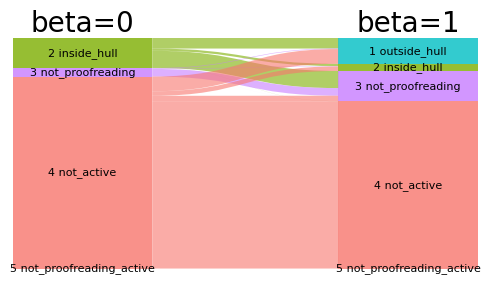

In [15]:
import sys

import sankey_mod
sys.path.append("./")



importlib.reload(sankey_mod)


sankey_raw = []


# Combine into a single array
group_names = [
    "1 outside_hull",
    "2 inside_hull",
    "3 not_proofreading",
    "4 not_active",
    "5 not_proofreading_active",
    "6 invalid",
]


def map_group_name(v):
    for name, boolean in zip(group_names, v):
        if boolean:
            return name

_betas = [0, 1]
for b in _betas:
    is_invalid = simulations.get_subset(
        subsets=None, not_subsets=[("valid", b)]
    )
    is_not_proofreading = simulations.get_subset(
        subsets=[("active", b)], not_subsets=[("proofreading", b)]
    )
    is_not_active = simulations.get_subset(
        subsets=[("proofreading", b)], not_subsets=[("active", b)]
    )
    is_not_proofreading_active = simulations.get_subset(
        subsets=[("valid", b)],
        not_subsets=[("proofreading", b), ("active", b)]
    )
    is_in_hull = simulations.get_subset(subsets=[("in_hull", b)])
    is_outside_hull = simulations.get_subset(
        subsets=[("proofreading", b), ("active", b)],
        not_subsets=[("in_hull", b)]
    )

    booleans = np.array([
        is_outside_hull,
        is_in_hull,
        is_not_proofreading,
        is_not_active,
        is_not_proofreading_active,
        is_invalid,
    ])

    sankey_raw.append(
        list(map(map_group_name, booleans.T))
    )

sankey_raw = np.array(sankey_raw)

sankey_table = {}

for sim in sankey_raw.T:
    if None in sim or "6 invalid" in sim:
        continue
    if tuple(sim) not in sankey_table:
        sankey_table[tuple(sim)] = 1
    else:
        sankey_table[tuple(sim)] += 1

# remove all zero-weight
keys = list(sankey_table.keys())
for i, k in enumerate(keys):
    if sankey_table[k] == 0:
        sankey_table.pop(k)



plt.figure(figsize=(6, 3))
sankey_mod.sankey(
    pd.DataFrame(
        [[sankey_table[k]] + list(k) for k in sankey_table],
        columns=["Weight"] + ["beta={}".format(b) for b in _betas],
    ),
    # since we have only one not proofreading & not active, just assign white for it
    nodes_color=ggcolors[4] + ["#FFFFFF"],
    labels_size=8,
    sort_flows_by_nodes=True
)
plt.savefig("sankey_full.svg")
plt.show()

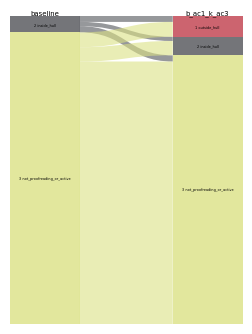

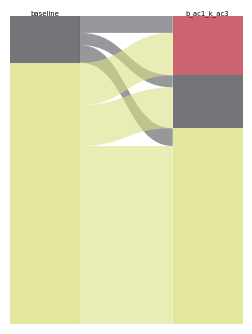

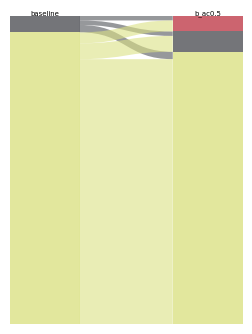

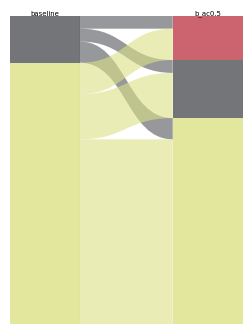

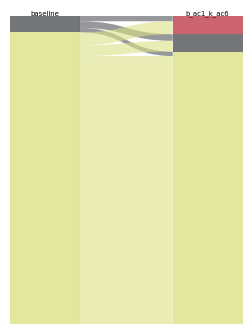

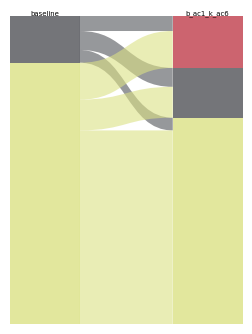

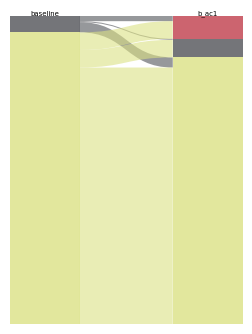

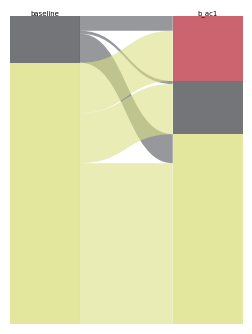

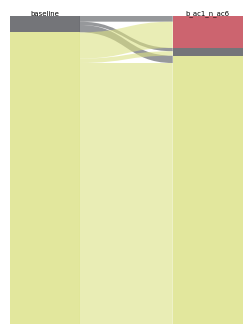

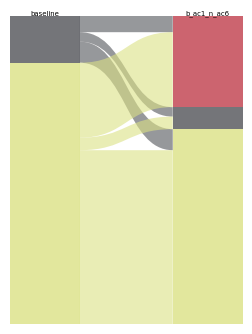

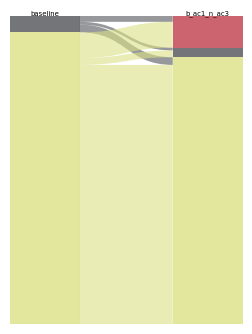

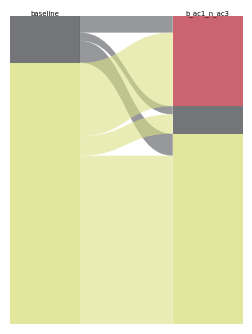

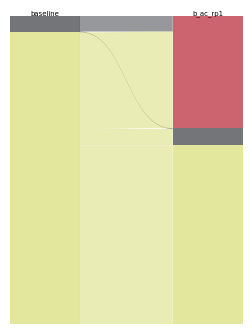

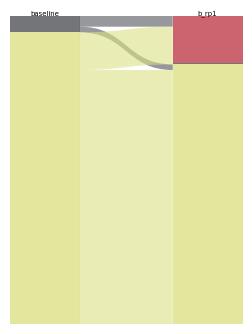

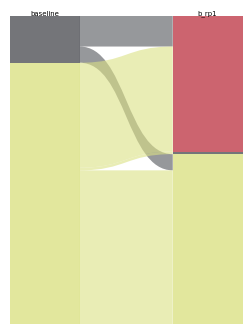

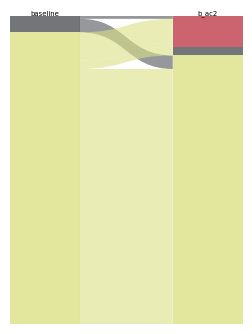

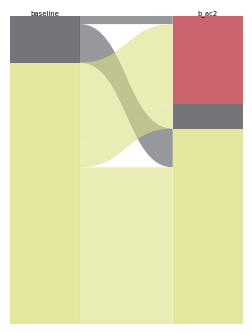

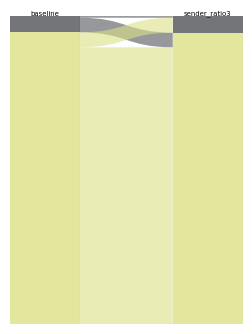

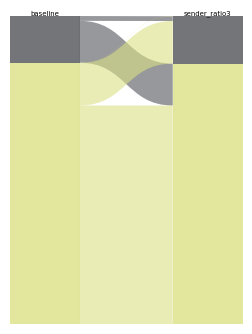

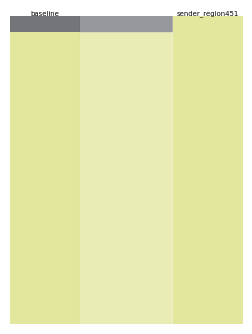

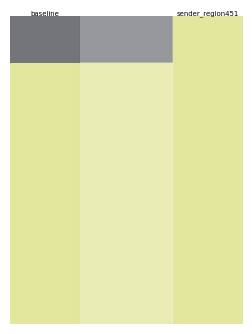

In [81]:
import importlib
import sys

import sankey_mod
sys.path.append("./")


importlib.reload(sankey_mod)


sankey_raw = []


# Combine into a single array
group_names = [
    "1 outside_hull",
    "2 inside_hull",
    "3 not_proofreading_or_active",
    "4 invalid",
]


def map_group_name(v):
    for name, boolean in zip(group_names, v):
        if boolean:
            return name


for b in betas:
    is_invalid = simulations.get_subset(
        subsets=None, not_subsets=[("valid", b)]
    )
    is_not_proofreading = simulations.get_subset(
        subsets=[("valid", b)],
        not_subsets=[("proofreading", b)]
    )
    is_not_active = simulations.get_subset(
        subsets=[("valid", b)],
        not_subsets=[("active", b)]
    )
    is_in_hull = simulations.get_subset(subsets=[("in_hull", b)])
    is_outside_hull = simulations.get_subset(
        subsets=[("proofreading", b), ("active", b)],
        not_subsets=[("in_hull", b)]
    )

    booleans = np.array([
        is_outside_hull,
        is_in_hull,
        np.bitwise_or(is_not_proofreading, is_not_active),
        is_invalid,
    ])

    sankey_raw.append(
        list(map(map_group_name, booleans.T))
    )

sankey_raw = np.array(sankey_raw)

zoomin_size = 14000
b0 = betas[0]
for i, b1 in enumerate(betas[1:]):
    # b1 = beta_dict[b1]
    sankey_raw_subset = sankey_raw[[0, i + 1], :]
    sankey_table = {}

    for sim in sankey_raw_subset.T:
        if None in sim or "4 invalid" in sim:
            continue
        if tuple(sim) not in sankey_table:
            sankey_table[tuple(sim)] = 1
        else:
            sankey_table[tuple(sim)] += 1

    # remove all zero-weight
    keys = list(sankey_table.keys())
    for k in keys:
        if sankey_table[k] == 0:
            sankey_table.pop(k)

    # remove color of outside .. if having no that value
    sankey_colors = ["#515358", "#dbe185"]
    keys = list(sankey_table)
    for k in keys:
        if k[1] == "1 outside_hull":
            sankey_colors = ["#515358", "#c03d4b", "#dbe185"]
            break

    plt.figure(figsize=(3, 4))
    sankey_mod.sankey(
        pd.DataFrame(
            [[sankey_table[k]] + list(k) for k in sorted(sankey_table)],
            columns=["Weight"] + [b0, b1],
        ),
        nodes_color=sankey_colors,
        sort_flows_by_nodes=True,
        labels_size=2.5,
        titles_size=5,
        labels_color="black" if i == 0 else None,
    )
    plt.savefig("sankey_merged_{} to {}.svg".format(b0, b1))
    plt.show()

    sim_count = 0
    for k in sankey_table:
        if k != ('3 not_proofreading_or_active', '3 not_proofreading_or_active'):
            sim_count += sankey_table[k]

    # skip zoom if got minus weight
    if zoomin_size < sim_count:
        continue
    sankey_table[
        ('3 not_proofreading_or_active', '3 not_proofreading_or_active')
    ] = zoomin_size - sim_count

    plt.figure(figsize=(3, 4))
    sankey_mod.sankey(
        pd.DataFrame(
            [[sankey_table[k]] + list(k) for k in sorted(sankey_table)],
            columns=["Weight"] + [b0, b1],
        ),
        nodes_color=sankey_colors,
        sort_flows_by_nodes=True,
        labels_size=2.5,
        titles_size=5,
        # labels_color="black" if i == 0 else None,
        labels_color=None if i == 0 else None,
    )

    plt.savefig("sankey_merged_zoom_{} to {}.svg".format(b0, b1))
    plt.show()

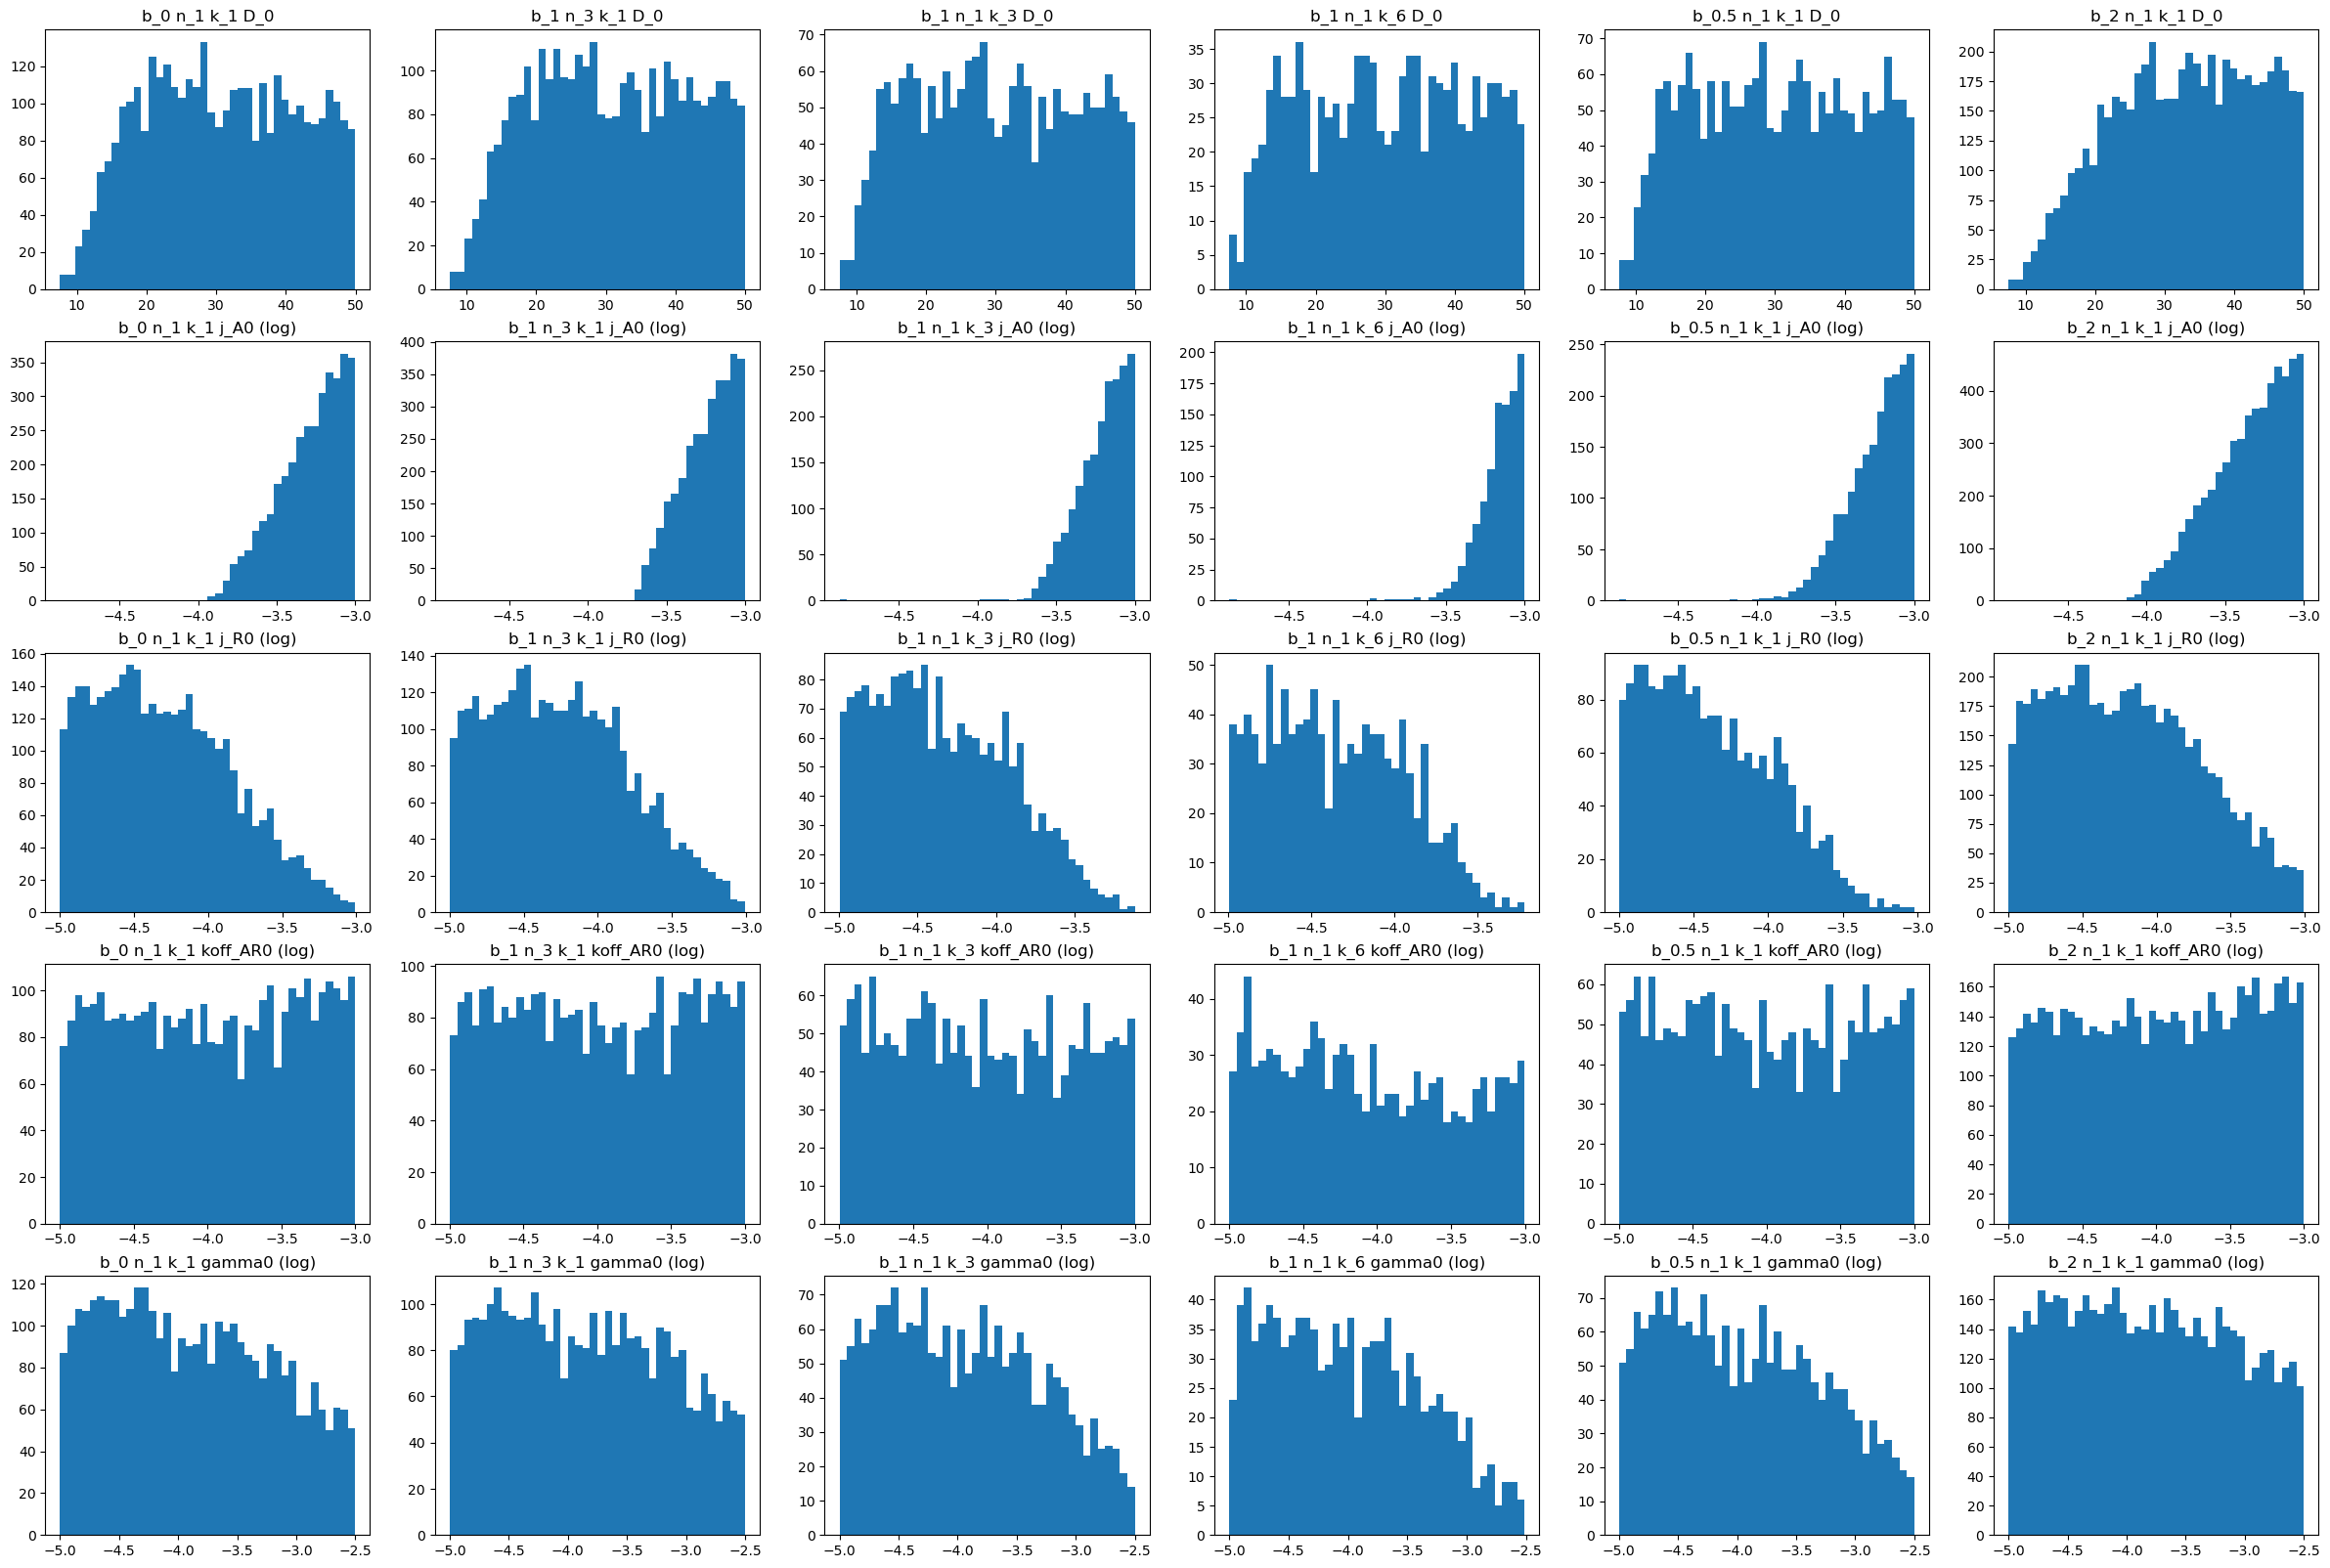

In [29]:
n_bins = 40

fig, axs = plt.subplots(5, 6, figsize=(30, 20))

b0 = beta_dict[betas[0]]
for i, b1 in enumerate(betas[1:]):
    worsened_indices = np.bitwise_and(
        sankey_raw[0] == "2 inside_hull",
        sankey_raw[i + 1] == "3 not_proofreading_or_active"
    )
    for j, (parameter, p_min, p_max) in enumerate(
        [
            ("D_0", 0, 50),
            ("j_A0 (log)", -5, -3),
            ("j_R0 (log)", -5, -3),
            ("koff_AR0 (log)", -5, -3),
            ("gamma0 (log)", -5, -2.5),
            # ("koff_AR0 + gamma0 (log)", np.log10(2e-5), np.log10(1e-3 + 10**-2.5)),
        ]
    ):
        bin_define = np.arange(p_min, p_max, (p_max - p_min) / n_bins)
        axs[j, i].hist(simulations.get_parameters_log()[worsened_indices, j], bins=n_bins)
        axs[j, i].title.set_text(beta_dict[b1] + " " + parameter)

plt.show()

    

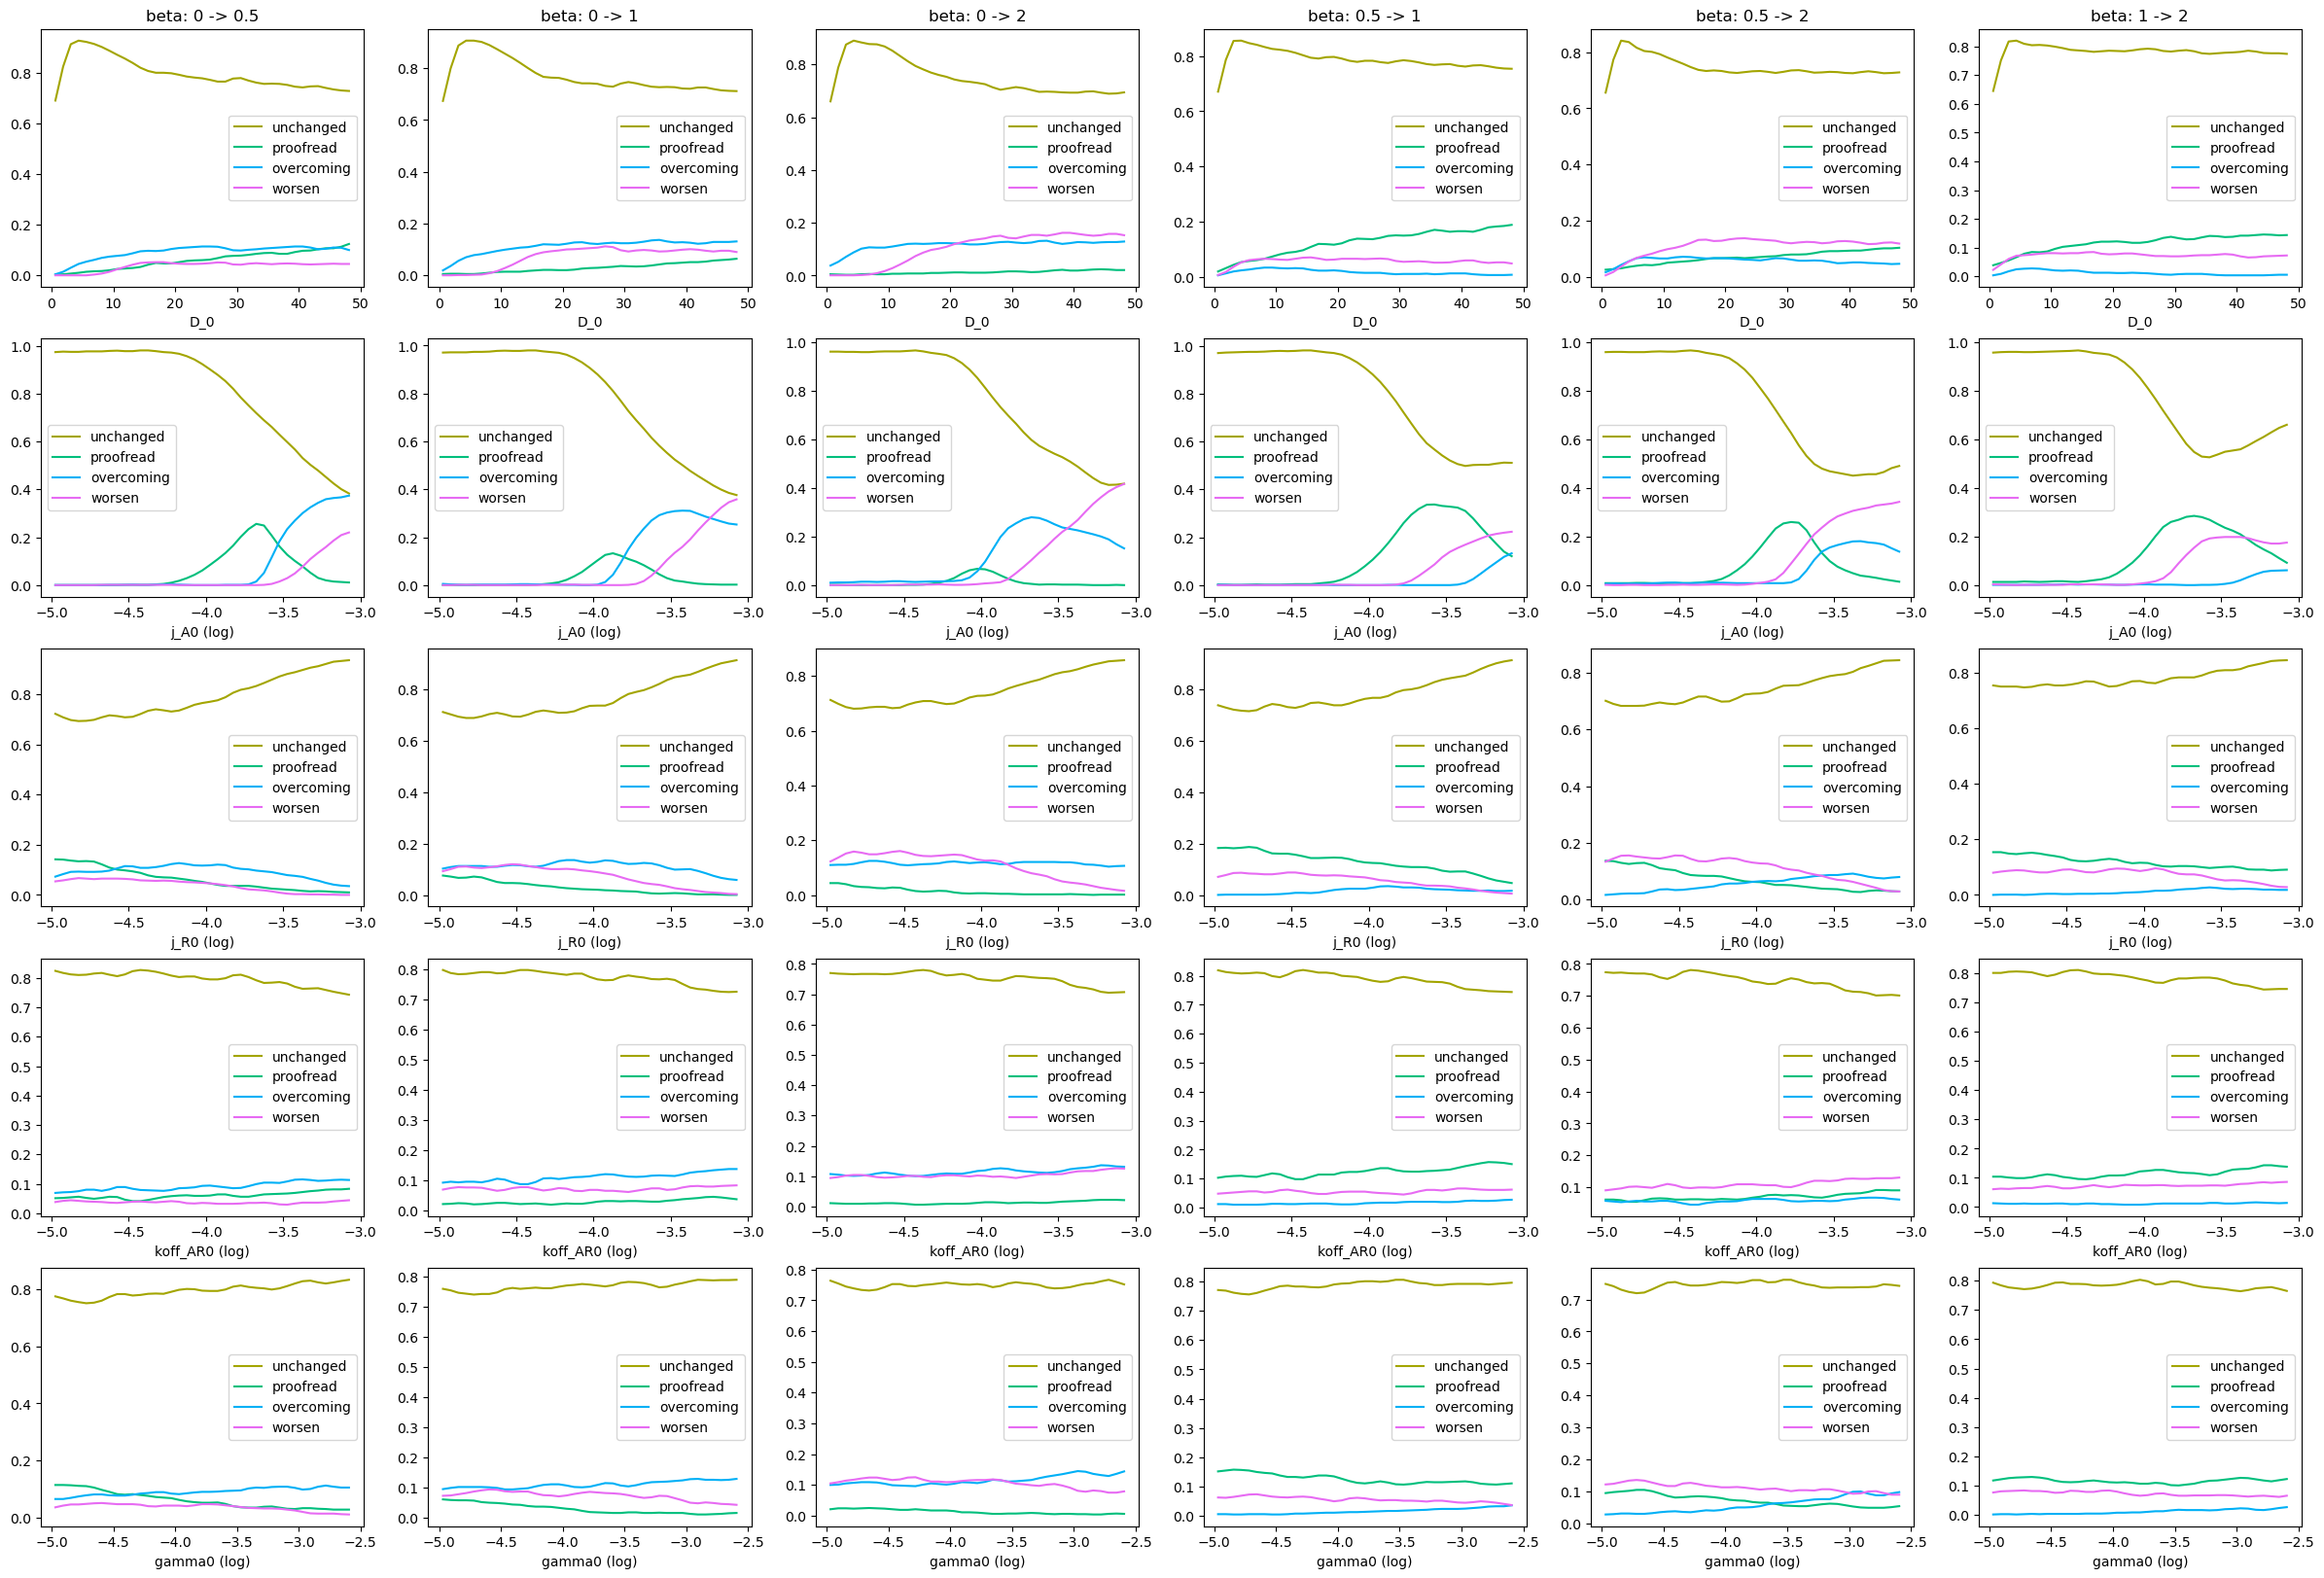

In [14]:
beta_combinations = list(combinations(betas, 2))
fig, axs = plt.subplots(
    5, len(beta_combinations),
    figsize=(5 * len(beta_combinations), 20)
)
for j, (b1, b2) in enumerate(beta_combinations):
    # recalculate hull for each b1
    hull = ConvexHull(
        np.array([
            simulations.get_fidelity_log(beta=b1, subsets=["proofreading", "active", "valid"]),
            simulations.get_AC_log(beta=b1, subsets=["proofreading", "active", "valid"]),
        ]).T
    )
    b1_is_not_proofreading_or_not_active = np.bitwise_or(
        simulations.get_subset(
            subsets=[("valid", b1)], not_subsets=[("proofreading", b1)]
        ),
        simulations.get_subset(
            subsets=[("valid", b1)], not_subsets=[("active", b1)]
        ),
    )
    b1_is_in_hull = simulations.get_subset(
        subsets=[("valid", b1), ("proofreading", b1), ("active", b1)]
    )
    b2_is_not_proofreading_or_not_active = np.bitwise_or(
        simulations.get_subset(
            subsets=[("valid", b2)], not_subsets=[("proofreading", b2)]
        ),
        simulations.get_subset(
            subsets=[("valid", b2)], not_subsets=[("active", b2)]
        ),
    )
    b2_is_in_hull = in_hull(
        np.array([
            simulations.get_fidelity_log(beta=b2),
            simulations.get_AC_log(beta=b2)
        ]).T,
        hull.points
    )
    b2_is_outside_hull = np.bitwise_and(
        simulations.get_subset(
            subsets=[("valid", b2), ("proofreading", b2), ("active", b2)],
        ),
        np.bitwise_not(b2_is_in_hull)
    )

    is_unchanged = np.bitwise_and(
        b1_is_not_proofreading_or_not_active,
        b2_is_not_proofreading_or_not_active
    )
    is_improved = np.bitwise_and(
        b1_is_not_proofreading_or_not_active,
        b2_is_in_hull,
    )
    is_proofreading = b2_is_in_hull
    is_overcoming_tradeoff = b2_is_outside_hull
    is_worsened = np.bitwise_and(
        b1_is_in_hull,
        b2_is_not_proofreading_or_not_active
    )
    
    # print(b1, b2)
    # print("unchanged", np.count_nonzero(is_unchanged))
    # print("improved", np.count_nonzero(is_improved))
    # print("overcoming", np.count_nonzero(is_overcoming_tradeoff))
    # print("worsened", np.count_nonzero(is_worsened))

    for i, (parameter, p_min, p_max) in enumerate(
        [
            ("D_0", 0, 50),
            ("j_A0 (log)", -5, -3),
            ("j_R0 (log)", -5, -3),
            ("koff_AR0 (log)", -5, -3),
            ("gamma0 (log)", -5, -2.5),
            # ("koff_AR0 + gamma0 (log)", np.log10(2e-5), np.log10(1e-3 + 10**-2.5)),
        ]
    ):
        bin_define = np.arange(p_min, p_max, (p_max - p_min) / n_bins)
        
        hist, edges = np.histogram(
            simulations.get_parameters_log()[is_unchanged, i],
            bins=bin_define
        )
        bin_centers = (edges[:-1] + edges[1:]) / 2
        smoothed_hist = gaussian_filter1d(hist, sigma=1)
        axs[i, j].plot(
            bin_centers, smoothed_hist / 1000,
            color=ggcolors[5][1],
            label="unchanged"
        )

        hist, edges = np.histogram(
            simulations.get_parameters_log()[is_proofreading, i],
            bins=bin_define
        )
        bin_centers = (edges[:-1] + edges[1:]) / 2
        smoothed_hist = gaussian_filter1d(hist, sigma=1)
        axs[i, j].plot(
            bin_centers, smoothed_hist / 1000,
            color=ggcolors[5][2],
            label="proofread"
        )

        hist, edges = np.histogram(
            simulations.get_parameters_log()[is_overcoming_tradeoff, i],
            bins=bin_define
        )
        bin_centers = (edges[:-1] + edges[1:]) / 2
        smoothed_hist = gaussian_filter1d(hist, sigma=1)
        axs[i, j].plot(
            bin_centers, smoothed_hist / 1000,
            color=ggcolors[5][3],
            label="overcoming"
        )

        hist, edges = np.histogram(
            simulations.get_parameters_log()[is_worsened, i],
            bins=bin_define
        )
        bin_centers = (edges[:-1] + edges[1:]) / 2
        smoothed_hist = gaussian_filter1d(hist, sigma=1)
        axs[i, j].plot(
            bin_centers, smoothed_hist / 1000,
            color=ggcolors[5][4],
            label="worsen"
        )

for ax in axs.flatten():
    ax.legend()
for ax, (b1, b2) in zip(axs[0], beta_combinations):
    ax.title.set_text("beta: {} -> {}".format(b1, b2))
for i, (row, parameter) in enumerate(zip(
    axs,
    [
        "D_0",
        "j_A0 (log)",
        "j_R0 (log)",
        "koff_AR0 (log)",
        "gamma0 (log)",
        "koff_AR0 + gamma0 (log)",
    ]
)):
    for ax in row:
        ax.set_xlabel(parameter)

plt.savefig("kde_change_vs_parameter.svg")
plt.show()

In [38]:
import zarr

NA = 6.022e23
h3 = grid_spacing * grid_spacing * grid_spacing * 1e-15

z = zarr.open("/run/media/cdmium/HDD_yanyuxuan/proofreading/result_20250216", mode="r")
meta_parameters = []
R_total = {}
for b in z.keys():
    print(b)
    group_b = z[b]
    R_total[b] = array_t[[Species.AR.value, Species.BR.value, Species.R.value], :, :]
    meta_parameters.append(group_b.attrs)
    t = "172800"
    array_t = group_b[t]

for k in R_total:
    R_total[k] = R_total[k].sum(axis=0)

baseline
b_ac0.5
b_ac1
b_ac1_k_ac3
b_ac1_n_ac3
b_ac1_k_ac6
sender_region451
b_ac_rp1
b_ac2
b_ac1_n_ac6
sender_ratio3
b_rp1


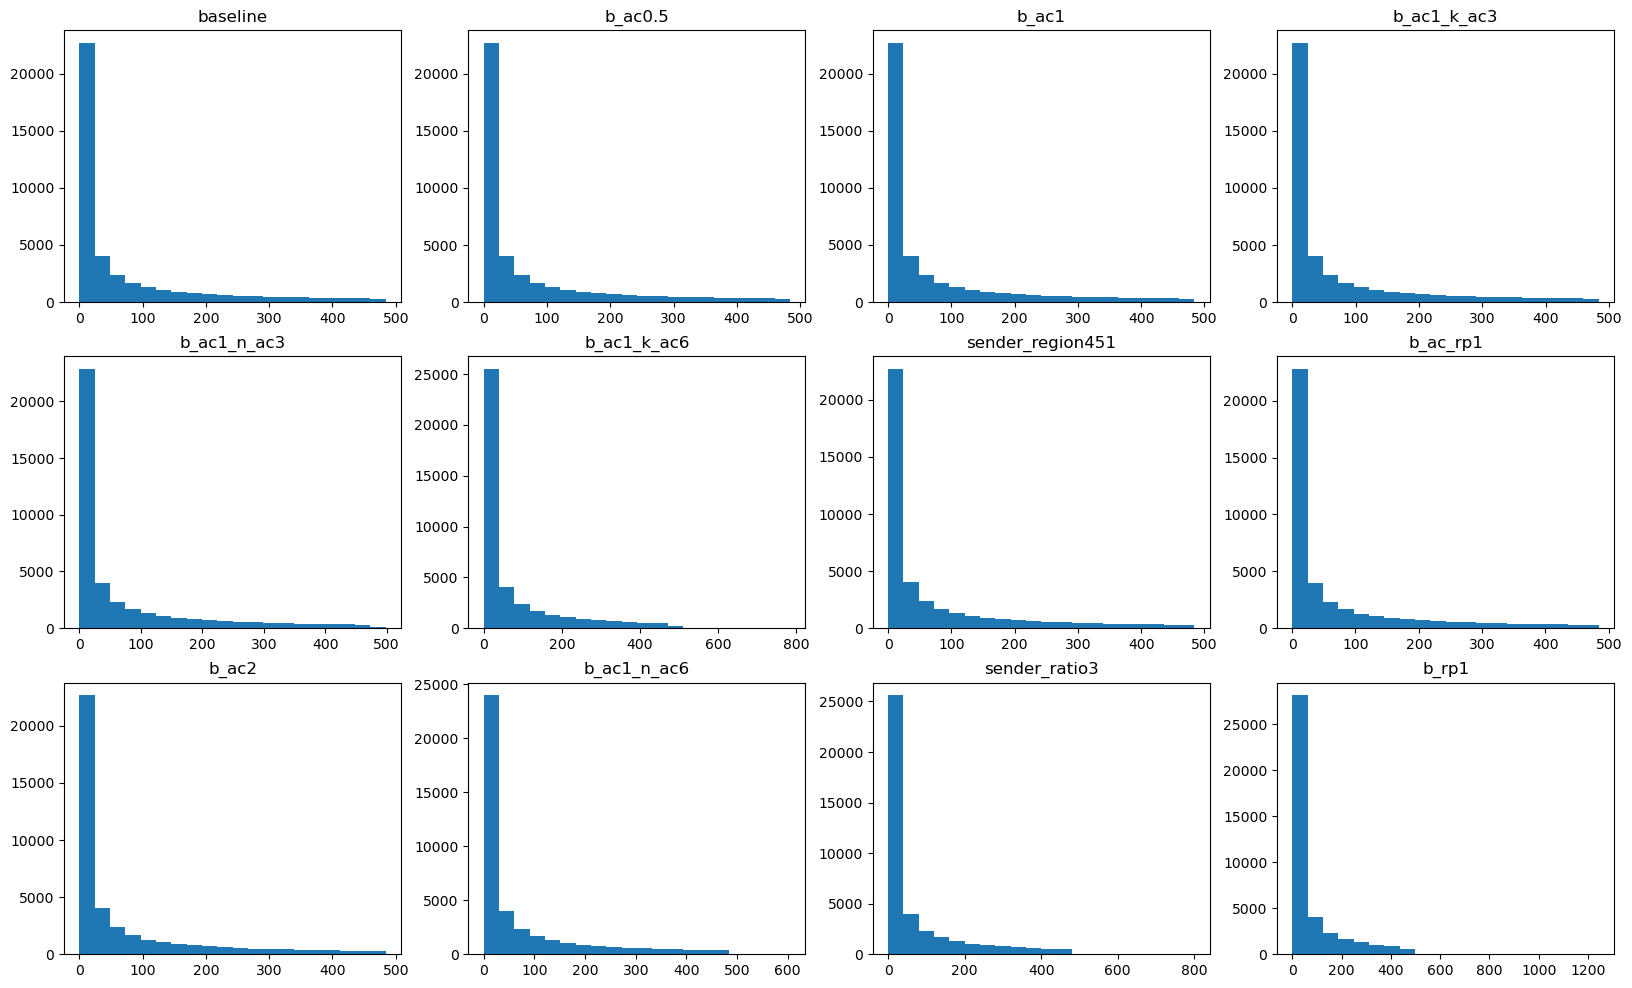

In [60]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12))
for (k, v), ax in zip(R_total.items(), axs.flatten()):
    c_R = v[:, 200:].mean(axis=1)
    c_R = c_R[c_R < 1e250]
    # receptor_per_cell = c_R * h3 * NA * 1e-9

    ax.hist(c_R, bins=20)
    ax.title.set_text(k)
    
plt.show()


    # print("{} concentration: {} nmole/L, {} receptor/cell".format(k, c_R, receptor_per_cell))